Notebook presenting basic rejection sampling algorithms for simulating an SIR process in a mean field population and on a network.

# Import libraries

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt


#from numpy.random import seed, rand
from numpy.random import Generator, PCG64, MT19937

In [2]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x0000019826A23EB0>


# Mean field SIR

## Functions 

In [3]:
def rejection_sampling_SIR_MF(beta_k, mu, dt, T, S, I, R):

    #--- Vector to save temporal evolution over time: ---
    X_t = np.zeros([3, int(T / dt) + 1])
    X_t[:,0] = [S,I,R]

    for i in range(int(T / dt)):
        #--- Infection and recovery probabilites in single time step: ---
        p_inf = S * I * beta_k * dt
        p_rec = I * mu * dt

        #--- Rejection sampling step: ---
        u1, u2 = rg.random(2)
        if u1 < p_inf:
            S -= 1
            I += 1
        if u2 < p_rec:
            I -= 1
            R += 1

        #--- Save current state to X_t: ---
        X_t[:,i+1] = [S,I,R]
        
    return(X_t)
##################################################################################################
##################################################################################################
def rejection_sampling_SIR_MF_individual(beta_k, mu, dt, T, S, I, R):

    #--- Vector to save temporal evolution over time: ---
    X_t = np.zeros([3, int(T / dt) + 1])
    X_t[:,0] = [S,I,R]

    for i in range(int(T / dt)):
        #--- Infection and recovery probabilites in single time step per individual: ---
        p_inf = I * beta_k * dt
        p_rec = mu * dt

        #--- Rejection sampling step for all individuals: ---
        u1s = rg.random(S)
        u2s = rg.random(I)      
        for u1 in u1s:
            if u1 < p_inf:
                S -= 1
                I += 1
        for u2 in u2s:
            if u2 < p_rec:
                I -= 1
                R += 1

        #--- Save current state to X_t: ---
        X_t[:,i+1] = [S,I,R]
        
    return(X_t)
##################################################################################################


## Individual-based rejection sampling
One reaction channel for each S individual (infection) and each I individual (recovery).

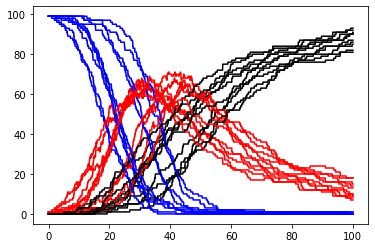

In [4]:

#--- Simulation parameters: ---
beta = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

beta_k = beta * float(k) / float(N) # Effective mean field infection rate

dt = 0.01 # Time step length

Q = 10

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(Q):    
    X_array.append(rejection_sampling_SIR_MF_individual(beta_k, mu, dt, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
times  = np.arange(0,T+dt,dt)

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(times,X_,c=c_) for X_,c_ in zip(X_t,colors)]

## Rejection sampling grouped by reaction type
Two reaction channels: 1) for an infection between of any S individual and 2) for a recovery of any infectious individual.

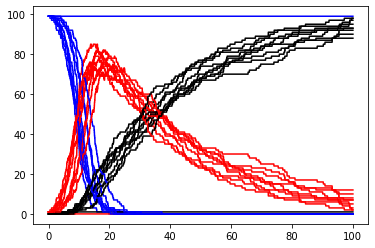

In [5]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

beta_k = beta * float(k) / float(N) # Effective mean field infection rate

dt = 0.01 # Time step length

Q = 10

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(Q):    
    X_array.append(rejection_sampling_SIR_MF(beta_k, mu, dt, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
times  = np.arange(0,T+dt,dt)

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(times,X_,c=c_) for X_,c_ in zip(X_t,colors)]

# SIR on network

In [6]:
##################################################################################################
def rejection_sampling_SIR_graph_simple(G, beta, mu, dt, T):
    #--- Infection and recovery probabilities per individual (pair) and per time-step: ---
    p_inf = beta * dt
    p_rec = mu * dt

    node_states = nx.get_node_attributes(G, 'state')
    N = len(node_states)
    S = sum(X==0 for X in node_states.values())
    I = sum(X==1 for X in node_states.values())
    R = N - S - I 
    
    #--- Vector to save temporal evolution over time: ---
    X_t = np.zeros([3, int(T / dt) + 1])
    X_t[:,0] = [S,I,R]

    #--- Loop over time in increments of dt: ---
    for n in range(int(T / dt)):
    #-------------------------------------------    
        new_I = []
        new_R = []
        
        #--- Loop over nodes in graph: ---
        for i in range(N):
        #---------------------------------    
            #--- If node is susceptible calculate total propensity and draw for infection: ---
            if G.nodes[i]['state'] == 0:
                neighbor_states = [G.nodes[j]['state'] for j in G.neighbors(i)]
                I_i = np.sum([state==1 for state in neighbor_states])
                if rg.random() < p_inf * I_i:
                    S -= 1
                    I += 1
                    new_I.append(i)

            #--- If node is infectious draw for recovery: ---
            elif G.nodes[i]['state'] == 1:
                #--- Rejection sampling step: ---
                if rg.random() < p_rec:
                    I -= 1
                    R += 1
                    new_R.append(i)
                    
        #--- Update state of nodes in graph: ---
        for i in new_I:
            G.nodes[i]['state'] = 1
        
        for i in new_R:
            G.nodes[i]['state'] = 2

        #--- Save current state to X_t: ---
        X_t[:,n+1] = [S,I,R]
#         states_t.append(nx.get_node_attributes(G, 'state'))
        
    return(X_t) #, states_t)
##################################################################################################


## $k$-regular graph 

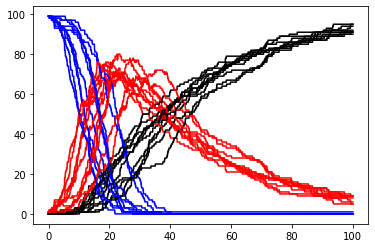

In [7]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Degree of nodes
N      = 100   # Number of nodes
T      = 100   # Simulation duration

dt = 0.01 # Time step length

Q = 10

G = nx.random_regular_graph(d=k, n=N)

X_array = []

for q in range(Q):
    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = rejection_sampling_SIR_graph_simple(G, beta, mu, dt, T)

    X_array.append(X_t)
#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
times  = np.arange(0,T+dt,dt)

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(times,X_,c=c_) for X_,c_ in zip(X_t,colors)]

## ER graph 

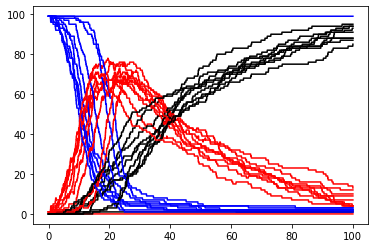

In [8]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

dt = 0.01 # Time step length

Q = 10

G = nx.gnm_random_graph(n=N, m=k*N/2)

X_array = []

for q in range(Q):
    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = rejection_sampling_SIR_graph_simple(G, beta, mu, dt, T)

    X_array.append(X_t)
#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
times  = np.arange(0,T+dt,dt)

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(times,X_,c=c_) for X_,c_ in zip(X_t,colors)]

##  BA graph

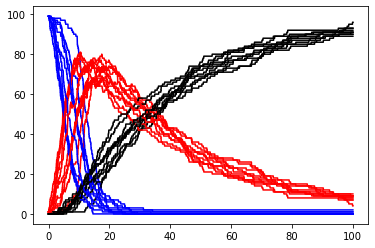

In [9]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 3     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

dt = 0.01 # Time step length

Q = 10

G = nx.barabasi_albert_graph(n=N, m=k)

X_array = []

for q in range(Q):
    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = rejection_sampling_SIR_graph_simple(G, beta, mu, dt, T)

    X_array.append(X_t)
#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
times  = np.arange(0,T+dt,dt)

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(times,X_,c=c_) for X_,c_ in zip(X_t,colors)]